In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score
import re

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback

In [2]:
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
DS_SPLIT = 0.2
MIN_SPECIALITY_THRESHOLD = 100
DATASET_PATH = 'data/mtsamples.csv'

dataset = pd.read_csv(DATASET_PATH, index_col=0)
dataset.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [3]:
def check_class_distribution(df):
    print("===== Class Distribution =====")
    counts = df.medical_specialty.value_counts()
    print(counts)

    plt.figure(figsize=(20, 10))
    counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Medical Specialty Counts')
    plt.xlabel('Medical Specialty')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def preprocess_data(df, show_plots=False):
    # Handling Missing Values
    null_summary = df.isnull().sum()
    print(f"===== Null Summary =====\n{null_summary}")
    if null_summary.any():
        print("Dropping rows with missing values...")
        df = df.dropna()

    # Checking for Duplicate Values
    duplicate_count = df.duplicated().sum()
    print(f"===== Duplicate Summary =====\nCount: {duplicate_count}")
    if duplicate_count > 0:
        print("Dropping duplicate rows...")
        df = df.drop_duplicates()

    df['transcription_clean'] = df['transcription'].map(clean_text)

    if show_plots:
        check_class_distribution(df)
    return df

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  4999 non-null   object
 1   transcription      4966 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB
None
===== Null Summary =====
medical_specialty     0
transcription        33
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 2
Dropping duplicate rows...
===== Class Distribution =====
medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharg

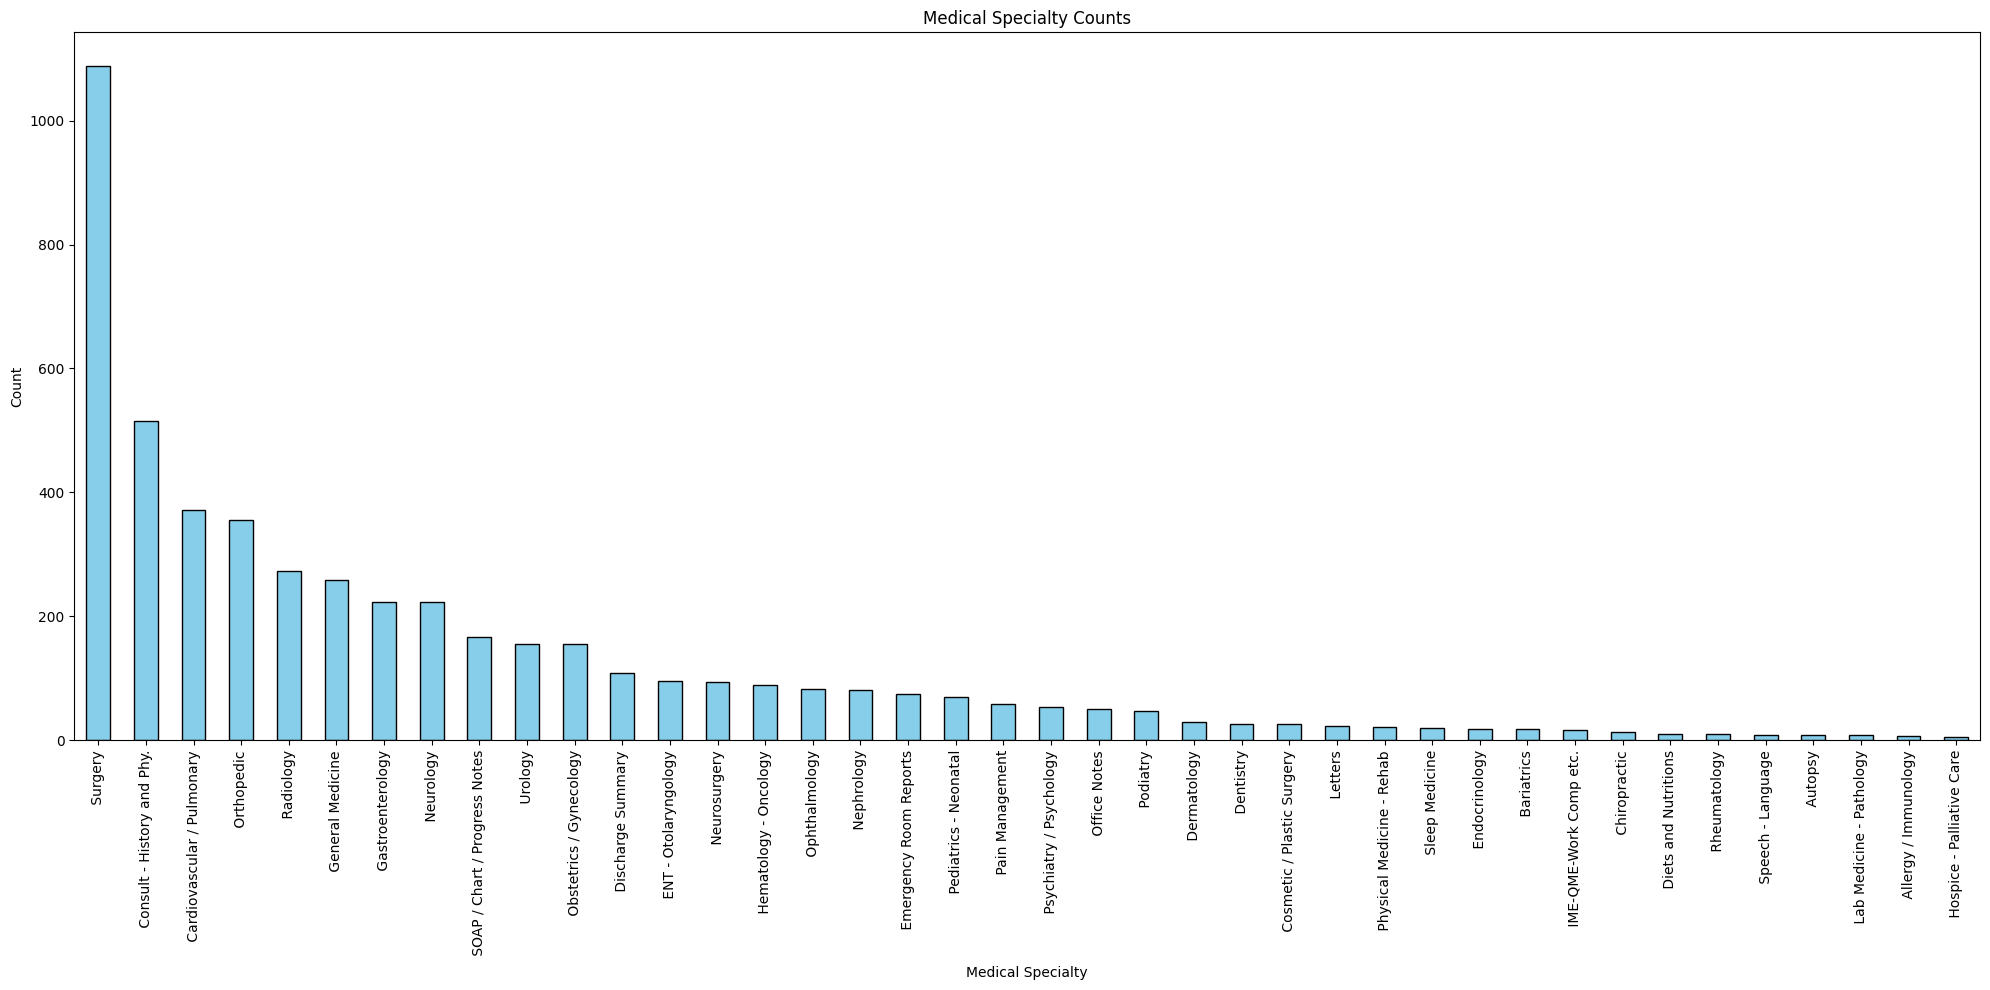

In [4]:
sub_ds = dataset[['medical_specialty', 'transcription']]
print(sub_ds.info())
sub_ds = preprocess_data(sub_ds, show_plots=True)

In [5]:
speciality_count = sub_ds.medical_specialty.value_counts()
filtered_ds = sub_ds[sub_ds.medical_specialty.isin(speciality_count[speciality_count >= MIN_SPECIALITY_THRESHOLD].index)]
filtered_ds.medical_specialty.value_counts()

medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
Name: count, dtype: int64

In [6]:
filtered_ds['medical_specialty_code'] = pd.factorize(filtered_ds['medical_specialty'])[0]
print(f"Shape: {sub_ds.shape}")
print(f"Unique code: {filtered_ds['medical_specialty_code'].unique()}")
filtered_ds.head()

Shape: (4964, 3)
Unique code: [ 0  1  2  3  4  5  6  7  8  9 10 11]


C:\Users\Mahfuzur\AppData\Local\Temp\ipykernel_13512\3791677866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ds['medical_specialty_code'] = pd.factorize(filtered_ds['medical_specialty'])[0]


,medical_specialty,transcription,transcription_clean,medical_specialty_code
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2 d m mode 1 left atrial enlargement with left...,0
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,1 the left ventricular cavity size and wall th...,0
7,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2 d echocardiogram multiple views of the heart...,0
9,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....",description 1 normal cardiac chambers size 2 n...,0
11,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...",2 d study 1 mild aortic stenosis widely calcif...,0


In [7]:
ros = RandomOverSampler(random_state=42)
df_resampled, y_resampled = ros.fit_resample(
    filtered_ds[['transcription_clean']],
    filtered_ds['medical_specialty_code']
)
df_resampled['label'] = y_resampled
print(f"Resampled Shape: {df_resampled.shape}")

Resampled Shape: (13056, 2)


In [8]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokens = tokenizer(
    df_resampled['transcription_clean'].tolist(),
    padding="max_length",
    truncation=True,
    max_length=MAX_SEQ_LEN,
    return_tensors="pt"
)
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
labels = torch.tensor(df_resampled["label"].values)

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

dataset = CustomDataset(input_ids, attention_mask, labels)
train_size = int((1 - DS_SPLIT) * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [10]:
codes, uniques = pd.factorize(filtered_ds["medical_specialty"])

label2id = {label: idx for idx, label in enumerate(uniques)}
id2label = {idx: label for idx, label in enumerate(uniques)}

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(uniques),
    id2label=id2label,
    label2id=label2id,
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

In [14]:
training_args = TrainingArguments(
    output_dir="./results",         
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    learning_rate=2e-5,             
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,             
    weight_decay=0.01,
    logging_dir="./logs",           
    logging_steps=10
)

trainer = Trainer(
    model=model,       
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.994300,1.004042,0.640888,0.594433
2,0.728800,0.869716,0.666922,0.634661
3,0.644500,0.801628,0.683767,0.657591
4,0.571900,0.775301,0.678407,0.655358
5,0.670600,0.781112,0.675345,0.649854


TrainOutput(global_step=3265, training_loss=0.8610701920975222, metrics={'train_runtime': 2474.2305, 'train_samples_per_second': 42.211, 'train_steps_per_second': 2.639, 'total_flos': 3459340593192960.0, 'train_loss': 0.8610701920975222, 'epoch': 5.0})

In [ ]:
torch.save(model, "models/distilbert_med.pth")